In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = True

Current Working Directory: progettoVIPM


In [4]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset

In [5]:
model = models.resnet50()
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("C:\\Users\\marco\\Desktop\\Uni\\Magistrale\\VIPM\\Progetto\\resnet50model.pth")['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
class ResNetFeatures(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatures, self).__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            original_model.relu,
            original_model.maxpool,
            original_model.layer1,
            original_model.layer2,
            original_model.layer3,
            original_model.layer4[:-1]  # Exclude the last bottleneck
        )
        self.last_bottleneck = original_model.layer4[-1]  # Extract last bottleneck separately
        self.avgpool = original_model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.last_bottleneck(x)  # Get features from the last bottleneck
        return x

In [8]:
feature_extractor = ResNetFeatures(model)

In [9]:
from torch.utils.data import DataLoader
trainData = datasets.TRAINING_LABELED
testData = datasets.TEST
train = ImageDataset(trainData,224,cuda=True)
test = ImageDataset(testData,224,cuda=True)
trainDL = DataLoader(train, batch_size=128, shuffle=True)
testDL = DataLoader(test, batch_size=128, shuffle=True)


In [10]:
feature_extractor.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)
all_features_train = []
all_labels_train = []
with torch.no_grad():
    for images, labels in trainDL:
        images = images.to(device)
        labels = [int(label) for label in labels]
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        features = feature_extractor(images)
        all_features_train.append(features.cpu().numpy())
        all_labels_train.append(labels.cpu().numpy())

In [11]:
feature_extractor.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)
all_features_test = []
all_labels_test = []
with torch.no_grad():
    for images, labels in testDL:
        images = images.to(device)
        labels = [int(label) for label in labels]
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        features = feature_extractor(images)
        all_features_test.append(features.cpu().numpy())
        all_labels_test.append(labels.cpu().numpy())

In [ ]:
all_features_train = np.concatenate(all_features_train, axis=0)
all_labels_train = np.concatenate(all_labels_train, axis=0)
all_features_test = np.concatenate(all_features_test, axis=0)
all_labels_test = np.concatenate(all_labels_test, axis=0)


In [24]:
all_features_train = all_features_train.reshape(all_features_train.shape[0], -1)
all_features_test = all_features_test.reshape(all_features_test.shape[0], -1)

In [25]:
print(all_features_train.shape)

(5020, 100352)


In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(all_features_train)
scaled_test = scaler.transform(all_features_test)
pca = PCA(n_components=500).fit(scaled_train)
X_train_pca = pca.transform(scaled_train)
x_test_pca = pca.transform(scaled_test)
print("Final input shape train: {}".format(X_train_pca.shape))
print("Final input shape test: {}".format(x_test_pca.shape))

Final input shape train: (5020, 500)
Final input shape test: (11994, 500)


 14%|█▍        | 1/7 [28:17<2:49:43, 1697.22s/it]

Linear Support Vector obtained following accuracy: 0.12039353009838252


 29%|██▊       | 2/7 [29:53<1:02:57, 755.44s/it] 

Rbf Support Vector obtained following accuracy: 0.18842754710688678


 43%|████▎     | 3/7 [30:43<28:53, 433.46s/it]  

KNN with 1 neighbors obtained following accuracy: 0.06995164248791062


 57%|█████▋    | 4/7 [31:34<14:06, 282.30s/it]

KNN with 10 neighbors obtained following accuracy: 0.07362014340503585


 71%|███████▏  | 5/7 [32:25<06:38, 199.06s/it]

KNN with 20 neighbors obtained following accuracy: 0.0783725195931299


 86%|████████▌ | 6/7 [33:13<02:27, 147.75s/it]

KNN with 50 neighbors obtained following accuracy: 0.0817075204268801


100%|██████████| 7/7 [34:22<00:00, 294.61s/it]

Naive Bayes obtained following accuracy: 0.11172252793063198


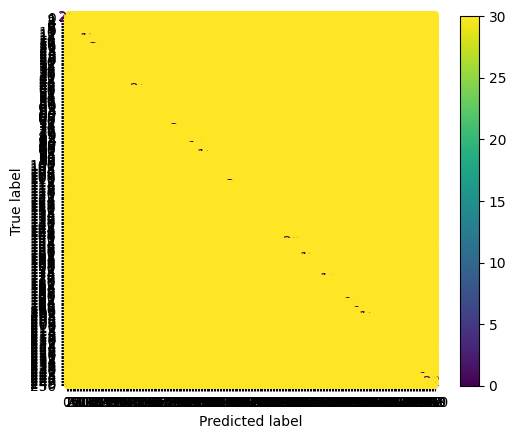

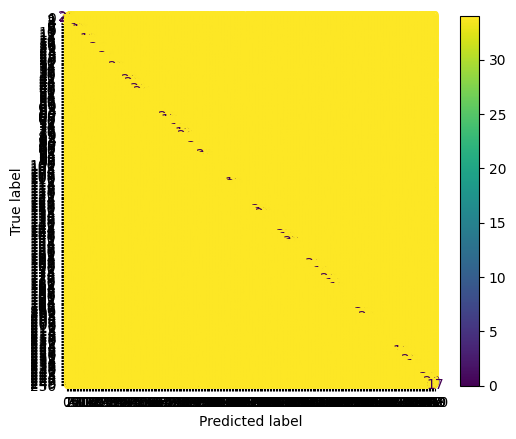

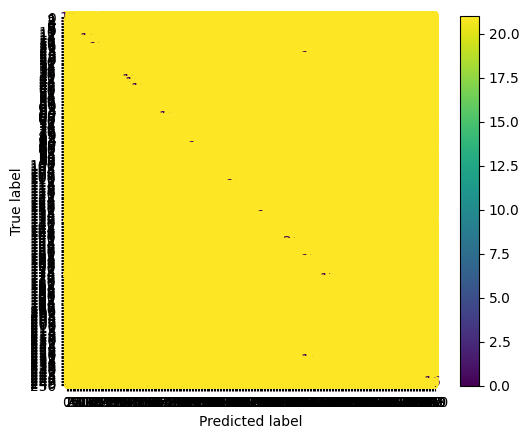

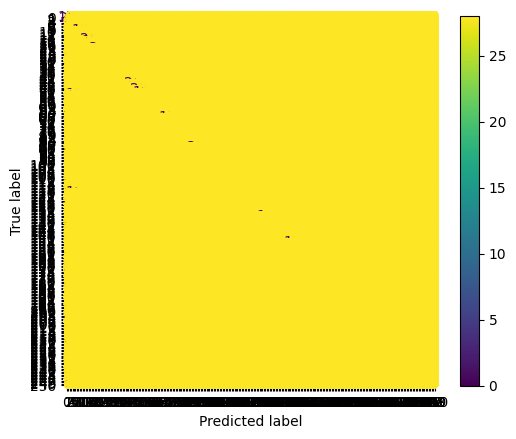

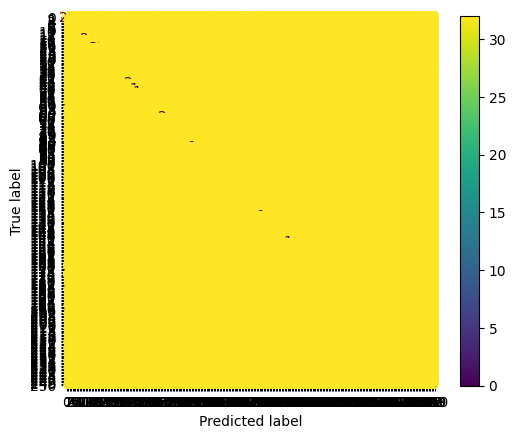

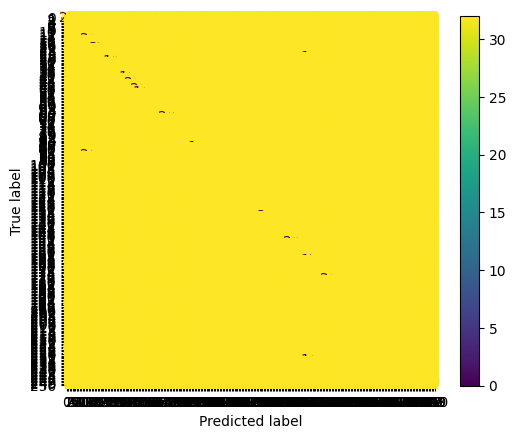

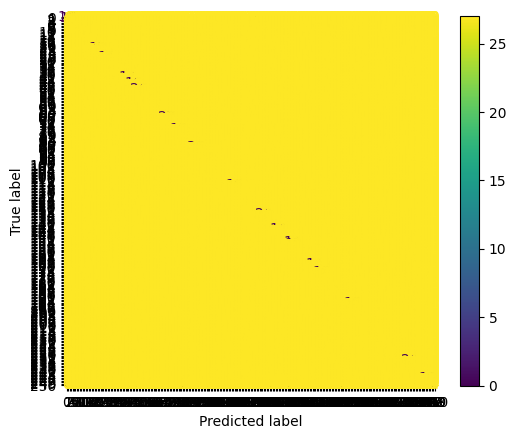

In [29]:
from enum import Enum
import pickle

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


class ml_models(Enum):
    LINEAR_SVC = [LinearSVC(), "Linear Support Vector"]
    RBF_SVC = [SVC(kernel="rbf"), "Rbf Support Vector"]
    # RANDOM_FOREST = [RandomForestClassifier(), "Random Forest"]
    # BOOSTED_FOREST = [GradientBoostingClassifier(), "Gradient Boosting Classifier"]
    KNN_1 = [KNeighborsClassifier(n_neighbors=1), "KNN with 1 neighbors"]
    KNN_10 = [KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"]
    KNN_20 = [KNeighborsClassifier(n_neighbors=20), "KNN with 20 neighbors"]
    KNN_50 = [KNeighborsClassifier(n_neighbors=50), "KNN with 50 neighbors"]
    NAIVE_BAYES = [GaussianNB(), "Naive Bayes"]
    
def model_building(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}.pdf".format(model_name))
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    with open('./Transfer_Learning/models/{}.pkl'.format(model_name),'wb') as f:
        pickle.dump(model,f)
    return acc
    

is_pca_used = True

x_train = X_train_pca
x_test = x_test_pca
if is_pca_used:
    x_train = X_train_pca
    x_test =x_test_pca
model_accuracies = []
for model in tqdm(ml_models):    
    model_name = "{}_from_{}_minus{}".format(model.value[1], "ResNet50", 1)
    if is_pca_used:
        model_name += "_pca"
    score = model_building(model.value[0], model_name, x_train, x_test, all_labels_train, all_labels_test)
    print("{} obtained following accuracy: {}".format(model.value[1],score))
    model_accuracies.append([model_name, score])
model_accuracies = np.array(model_accuracies)
accuracies_filename = "./Transfer_Learning/model_metrics/Accuracies_{}_minus{}".format("ResNet50", 1)
if is_pca_used:
    accuracies_filename += "_pca"
np.save("{}.npy".format(accuracies_filename), model_accuracies)